<a href="https://colab.research.google.com/github/nicole-hjlin/mpala-tree-mapping/blob/main/geomap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeoMap

Matching location data of .las files (LiDAR) with specific tree IDs and ForestGeo Tree Species Labels.

In [1]:
!pip3 install lasio laspy
!pip3 install utm
!pip3 install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 318 kB/s 
     |████████████████████████████████| 615 kB 7.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for laspy: filename=laspy-2.3.0-py3-none-any.whl size=65013 sha256=44aa0170cb741fb21168667763a262b33fdf4cb623e1341b58b1b427b283fc2f
  Stored in directory: /root/.cache/pip/wheels/81/d6/4c/712b266bbb1dcf070bd9a51a4d660173e3c60a0b426f2cef02
Successfully built laspy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6108 sha256=d7cd0d0e46f340fbf25fb8525baf26b693a1bacb08e4a4108ef2b5f5354e6b41
  Stored in directory: /root/.cache/pip/wheels/a5/b0/12/7ee4fdb0f9fbb4157100bd02390436ed5d58ebfd3c6d6a0886
Successfully built utm
Looking in

In [2]:
# Mount Google Drive (where data sit)
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
# Set Project Folder
import os
header = '/content/drive/My Drive'
hongjin_path = 'classes/2022 fall/CS 288 AI for Social Impact/CS288 Final Project - Tree Species'
derek_path = 'jr/CS288 Final Project - Tree Species'
matt_path = ''

# Select path from above
project_path = os.path.join(header, hongjin_path)
project_path

'/content/drive/My Drive/classes/2022 fall/CS 288 AI for Social Impact/CS288 Final Project - Tree Species'

In [4]:
# Import code utilities files
import sys
sys.path.insert(0, os.path.join(project_path, 'mpala-tree-mapping'))

In [5]:
# import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from osgeo import gdal
import laspy
import utm
import pickle
import geopandas
import geopy.distance

## Convert location data to lat and long

### ForestGEO Labels

In [ ]:
# read data
forestgeo = pd.read_csv(os.path.join(project_path, 'PlotDataReport10-07-2022_1734418034.txt'), delimiter = "\t")
forestgeo.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,No.,Latin,Mnemonic,SubSpecies,Quadrat,PX,PY,TreeID,Tag,StemID,StemTag,Census,DBH,HOM,Date,Codes,Stem,Status
0,1,Acacia brevispica,ACACBR,NaN,221,36.30040,400.50461,124386,20847,254971,020847,1,77.0,0.5,2012-11-20,NaN,main,alive
1,2,Acacia brevispica,ACACBR,NaN,311,51.84520,206.57974,124814,30407,255478,030407,1,37.0,0.5,2012-11-17,NaN,main,alive
2,3,Acacia brevispica,ACACBR,NaN,503,81.23257,58.41180,126361,50086,257294,050086,1,50.0,0.5,2012-11-23,NaN,main,alive
3,4,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262757,1000015,1,23.0,0.5,2014-11-15,M,main,alive
4,5,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262758,1000016,1,23.0,0.5,2014-11-15,NaN,NaN,alive


In [ ]:
# keep records with location data 
r_remove = sum((forestgeo['PX'].isna()) & (forestgeo['PY'].isna()))/len(forestgeo)*100
print('Removing {}% records with missing location data. '.format(r_remove)) 
forestgeo = forestgeo[(~forestgeo['PX'].isna()) & (~forestgeo['PY'].isna())]

Removing 2.2284298537635827% records with missing location data. 


In [ ]:
# 2022-11-02: added Tyler's approximation of the northwest corner post
forestgeo_grid = geopandas.read_file(os.path.join(project_path, 'ForestGEO_Grid', 'ForestGEO_Grid.shp'))
nw_corner_latlong = utm.to_latlon(min(forestgeo_grid['left']), max(forestgeo_grid['top']), 37, 'N')
print(min(forestgeo_grid['left']))
print(max(forestgeo_grid['top']))
print('Northwest corner post: ', nw_corner_latlong)
forestgeo_grid.head()

256330.0472
35684.7414
Northwest corner post:  (0.322613787883293, 36.81070166797714)


,id,left,top,right,bottom,Quadrat,geometry
0,1.0,256330.0472,35684.7414,256350.0472,35664.7414,101,"POLYGON ((262689.296 31846.312, 262707.340 318..."
1,2.0,256330.0472,35664.7414,256350.0472,35644.7414,102,"POLYGON ((262697.923 31828.268, 262715.967 318..."
2,3.0,256330.0472,35644.7414,256350.0472,35624.7414,103,"POLYGON ((262706.549 31810.224, 262724.593 318..."
3,4.0,256330.0472,35624.7414,256350.0472,35604.7414,104,"POLYGON ((262715.176 31792.180, 262733.220 318..."
4,5.0,256330.0472,35604.7414,256350.0472,35584.7414,105,"POLYGON ((262723.802 31774.136, 262741.846 317..."


In [ ]:
# check grid boundary in lat long
print('Northwest: ', utm.to_latlon(min(forestgeo_grid['left']), max(forestgeo_grid['top']), 37, 'N'))
print('Southwest: ', utm.to_latlon(min(forestgeo_grid['left']), min(forestgeo_grid['bottom']), 37, 'N'))
print('Northeast: ', utm.to_latlon(max(forestgeo_grid['right']), max(forestgeo_grid['top']), 37, 'N'))
print('Southeast: ', utm.to_latlon(max(forestgeo_grid['right']), min(forestgeo_grid['bottom']), 37, 'N'))

Northwest:  (0.322613787883293, 36.81070166797714)
Southwest:  (0.31809345666931366, 36.81070262773725)
Northeast:  (0.3226184346004927, 36.83225450753058)
Southeast:  (0.3180980382650492, 36.83225545786032)


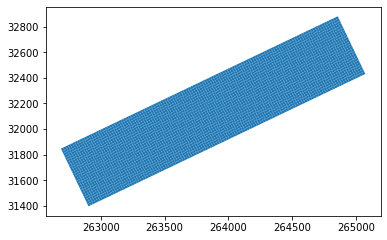

In [ ]:
forestgeo_grid.plot()
plt.show()

In [ ]:
# convert location data PX and PY to lat and long for data matching
## cite: https://stackoverflow.com/questions/7477003/calculating-new-longitude-latitude-from-old-n-meters

def forestgeo_to_latlong(origin_latlong, south_dis_meters, east_dis_meters):
  """
  local helper function
  returns the lat and long of a geo point knowing the base point coordinates in lat and long and distance from the base point in meters due south and east
  
  parameters: 
  origin_latlong: (lat, long)
  south_dis_meters: distance from the original point due south in meters
  east_dis_meters: distance from the original point due east in meters

  returns:
  new_lat: float
    latitude of the new geo point
  new_long: float
    longitude of the new geo point
  """
  origin = geopy.Point(origin_latlong)
  # south. distance PY. bearing due south is 180
  new_lat = geopy.distance.geodesic(meters=south_dis_meters).destination(origin, 180).latitude 
  # east. distance PX. bearing due east is 90
  new_long = geopy.distance.geodesic(meters=east_dis_meters).destination(origin, 90).longitude 
  return new_lat, new_long

In [ ]:
# test local function for calculating new geo point
## the output should approximate the northwest point of the 102 quadrat
new_latlong = forestgeo_to_latlong(nw_corner_latlong, south_dis_meters = 20, east_dis_meters = 0)
print(utm.from_latlon(new_latlong[0], new_latlong[1])) 
forestgeo_grid[forestgeo_grid['Quadrat'] == 102]

(256330.04289776963, 35664.736389729085, 37, 'N')


,id,left,top,right,bottom,Quadrat,geometry
1,2.0,256330.0472,35664.7414,256350.0472,35644.7414,102,"POLYGON ((262697.923 31828.268, 262715.967 318..."


In [ ]:
# test local function for calculating new geo point
## the output should approximate the northwest point of the 201 quadrat
new_latlong = forestgeo_to_latlong(nw_corner_latlong, south_dis_meters = 0, east_dis_meters = 20)
print(utm.from_latlon(new_latlong[0], new_latlong[1])) 
forestgeo_grid[forestgeo_grid['Quadrat'] == 201]

(256350.05390295415, 35684.73878437136, 37, 'N')


,id,left,top,right,bottom,Quadrat,geometry
25,101.0,256350.0472,35684.7414,256370.0472,35664.7414,201,"POLYGON ((262707.340 31854.938, 262725.384 318..."


In [ ]:
# convert location data px and py to lat and long
new_lat_lst = []
new_long_lst = []
for i in range(len(forestgeo)):
  new_lat, new_long = forestgeo_to_latlong(nw_corner_latlong, south_dis_meters = forestgeo.iloc[i].PY, east_dis_meters = forestgeo.iloc[i].PX)
  new_lat_lst.append(new_lat)
  new_long_lst.append(new_long)
forestgeo['latitude'] = new_lat_lst
forestgeo['longitude'] = new_long_lst
forestgeo.head()  

,No.,Latin,Mnemonic,SubSpecies,Quadrat,PX,PY,TreeID,Tag,StemID,StemTag,Census,DBH,HOM,Date,Codes,Stem,Status,latitude,longitude
0,1,Acacia brevispica,ACACBR,NaN,221,36.30040,400.50461,124386,20847,254971,020847,1,77.0,0.5,2012-11-20,NaN,main,alive,0.318992,36.811028
1,2,Acacia brevispica,ACACBR,NaN,311,51.84520,206.57974,124814,30407,255478,030407,1,37.0,0.5,2012-11-17,NaN,main,alive,0.320746,36.811167
2,3,Acacia brevispica,ACACBR,NaN,503,81.23257,58.41180,126361,50086,257294,050086,1,50.0,0.5,2012-11-23,NaN,main,alive,0.322086,36.811431
3,4,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262757,1000015,1,23.0,0.5,2014-11-15,M,main,alive,0.322528,36.828512
4,5,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262758,1000016,1,23.0,0.5,2014-11-15,NaN,NaN,alive,0.322528,36.828512


In [ ]:
# verify if approximation is within the quadrat
i = 1234
sample = forestgeo.iloc[i]
new_point = utm.from_latlon(sample.latitude, sample.longitude)
new_lat = new_point[0]
new_long = new_point[1]
grid = forestgeo_grid[forestgeo_grid.Quadrat == sample.Quadrat]
print((grid.left.values[0] <= new_lat) and (new_lat <= grid.right.values[0]))
print((grid.bottom.values[0] <= new_long) and (new_long <= grid.top.values[0]))

#utm.from_latlon(sample.latitude, sample.longitude)[0]

True
True


In [ ]:
# save new data table for fast processing later
with open(os.path.join(project_path, 'outputs', 'forestgeo_with_latlong.pickle'), 'wb') as f:
    pickle.dump(forestgeo, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# read saved data table with approximated lat and long
with open(os.path.join(project_path, 'outputs', 'forestgeo_with_latlong.pickle'), 'rb') as f:
    forestgeo = pickle.load(f)
forestgeo.head()

,No.,Latin,Mnemonic,SubSpecies,Quadrat,PX,PY,TreeID,Tag,StemID,StemTag,Census,DBH,HOM,Date,Codes,Stem,Status,latitude,longitude
0,1,Acacia brevispica,ACACBR,NaN,221,36.30040,400.50461,124386,20847,254971,020847,1,77.0,0.5,2012-11-20,NaN,main,alive,0.318992,36.811028
1,2,Acacia brevispica,ACACBR,NaN,311,51.84520,206.57974,124814,30407,255478,030407,1,37.0,0.5,2012-11-17,NaN,main,alive,0.320746,36.811167
2,3,Acacia brevispica,ACACBR,NaN,503,81.23257,58.41180,126361,50086,257294,050086,1,50.0,0.5,2012-11-23,NaN,main,alive,0.322086,36.811431
3,4,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262757,1000015,1,23.0,0.5,2014-11-15,M,main,alive,0.322528,36.828512
4,5,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262758,1000016,1,23.0,0.5,2014-11-15,NaN,NaN,alive,0.322528,36.828512


### LiDAR Images

In [ ]:
# Data Paths
lidar_path = os.path.join(project_path, 'MpalaForestGEOPlotData', 'data')
high_res_path = os.path.join(lidar_path, 'HighResAcquisitions')
# segmented tree images
tree_files = os.listdir(os.path.join(lidar_path, 'HighResAcquisitions', 'MpalaForestGEO_LasClippedtoTreePolygons'))
print(len(tree_files))
tree_files[:5]

43709


['treeID_42693.las',
 'treeID_42718.las',
 'treeID_42716.las',
 'treeID_42730.las',
 'treeID_42715.las']

In [ ]:
tree_ids = [int(i[7:-4]) for i in tree_files]
tree_ids.sort()
max(tree_ids) == len(tree_ids)
print(len(tree_ids))

43709


In [ ]:
# convert LiDAR location data to lat long coordinates
## Mpala coordinates: 1.0822850033164138, 37.149144200529584
## cite https://github.com/Turbo87/utm
## UTM zone system: https://www.usgs.gov/faqs/how-are-utm-coordinates-measured-usgs-topographic-maps#:~:text=The%20UTM%20(Universal%20Transverse%20Mercator,Zone%2019%2C%20which%20includes%20Maine.

# get the zone number and zone letter from Mpala's coordinates
utm.from_latlon(1.0822850033164138, 37.149144200529584)

(294046.54747902136, 119688.00302557605, 37, 'N')

In [ ]:
sample_tree = laspy.read(os.path.join(high_res_path, 'MpalaForestGEO_LasClippedtoTreePolygons', 'treeID_1234.las'))
print(list(sample_tree.point_format.dimension_names)) 
print(sample_tree.X[:5])
print(sample_tree.Y[:5])

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time', 'red', 'green', 'blue', 'HeightAboveGround']
[26369375 26369426 26369319 26369460 26369485]
[3231734 3231760 3231666 3231776 3231791]


In [ ]:
# sample tree point lat longs 
scaleX = sample_tree.header.scale[0]
scaleY = sample_tree.header.scale[1]
print(scaleX)
print(scaleY)
sample_latlong = utm.to_latlon(sample_tree.X*scaleX, sample_tree.Y*scaleY, 37, 'N')
# approximate the location of the tree by taking the average of the points 
print(np.average(sample_latlong, axis = 1))

0.01
0.01
[ 0.2921932  36.87683431]


In [ ]:
%timeit
# generate the lat and long of points for each tree and save outputs for downstream matching

latlong_dict = {}
for i, t in enumerate(tree_files):
  print(f'{i}/{len(tree_files)}', end='\r')
  # read las file 
  las = laspy.read(os.path.join(high_res_path, 'MpalaForestGEO_LasClippedtoTreePolygons', t))
  scaleX = las.header.scale[0]
  scaleY = las.header.scale[1]
  latlongs = utm.to_latlon(las.X*scaleX, las.Y*scaleY, 37, 'N')
  latlongs_avg = np.average(latlongs, axis = 1)
  latlong_dict[t[:-4]] = latlongs, latlongs_avg

KeyboardInterrupt: ignored

^ stopped early because it is taking a long time. We should verify a few samples before conversion with the full dataset.

In [ ]:
# save new data table for fast processing later
with open(os.path.join(project_path, 'outputs', 'lidar_with_latlong.pickle'), 'wb') as f:
    pickle.dump(latlong_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# read saved data table with approximated lat and long
with open(os.path.join(project_path, 'outputs', 'lidar_with_latlong.pickle'), 'rb') as f:
    latlong_dict = pickle.load(f)

In [ ]:
len(latlong_dict)

2087

In [ ]:
lat_lst = []
long_lst = []
for tree_id in latlong_dict.keys():
  lat_lst.append(latlong_dict[tree_id][1][0])
  long_lst.append(latlong_dict[tree_id][1][1])

tree_dict = pd.DataFrame()
tree_dict['tree_id'] = latlong_dict.keys()
tree_dict['latitude'] = lat_lst
tree_dict['longitude'] = long_lst
tree_dict.head()

,tree_id,latitude,longitude
0,treeID_42693,0.284333,36.869064
1,treeID_42718,0.284321,36.871805
2,treeID_42716,0.284316,36.870929
3,treeID_42730,0.284316,36.871608
4,treeID_42715,0.284332,36.870756


In [ ]:
len(tree_dict)

2087

## Match species labels with LiDAR images

In [ ]:
forestgeo.head()

,No.,Latin,Mnemonic,SubSpecies,Quadrat,PX,PY,TreeID,Tag,StemID,StemTag,Census,DBH,HOM,Date,Codes,Stem,Status,latitude,longitude
0,1,Acacia brevispica,ACACBR,NaN,221,36.30040,400.50461,124386,20847,254971,020847,1,77.0,0.5,2012-11-20,NaN,main,alive,0.318992,36.811028
1,2,Acacia brevispica,ACACBR,NaN,311,51.84520,206.57974,124814,30407,255478,030407,1,37.0,0.5,2012-11-17,NaN,main,alive,0.320746,36.811167
2,3,Acacia brevispica,ACACBR,NaN,503,81.23257,58.41180,126361,50086,257294,050086,1,50.0,0.5,2012-11-23,NaN,main,alive,0.322086,36.811431
3,4,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262757,1000015,1,23.0,0.5,2014-11-15,M,main,alive,0.322528,36.828512
4,5,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262758,1000016,1,23.0,0.5,2014-11-15,NaN,NaN,alive,0.322528,36.828512


In [ ]:
tree_dict.head()

,tree_id,latitude,longitude
0,treeID_42693,0.284333,36.869064
1,treeID_42718,0.284321,36.871805
2,treeID_42716,0.284316,36.870929
3,treeID_42730,0.284316,36.871608
4,treeID_42715,0.284332,36.870756


In [ ]:
# initial matching attempt
match_digit = 4
tree_dict['latitude_short'] = tree_dict['latitude'].round(match_digit)
tree_dict['longitude_short'] = tree_dict['longitude'].round(match_digit)
forestgeo['latitude_short'] = forestgeo['latitude'].round(match_digit)
forestgeo['longitude_short'] = forestgeo['longitude'].round(match_digit)

pd.merge(forestgeo[forestgeo['Stem'] == 'main'][['TreeID', 'Latin', 'latitude_short', 'longitude_short']], tree_dict[['tree_id', 'latitude_short', 'longitude_short']], how='inner', on = ['latitude_short', 'longitude_short'])

,TreeID,Latin,latitude_short,longitude_short,tree_id


2022-11-03 matching unsuccessful
1. check overlap of geo grid of the two datasets
2. check sample tree

Check geo boundraies of the two datasets

In [ ]:
print(min(tree_dict.latitude_short))
print(max(tree_dict.latitude_short))
print(min(tree_dict.longitude_short))
print(max(tree_dict.longitude_short))

0.2834
0.2852
36.8685
36.8736


In [ ]:
print(min(forestgeo.latitude))
print(max(forestgeo.latitude))
print(min(forestgeo.longitude))
print(max(forestgeo.longitude))

0.31809216077487606
0.3226136297995587
36.81070208767665
36.83226061800827


In [ ]:
lidar_grid = geopandas.read_file(os.path.join(project_path, 'MpalaForestGEOPlotData', 'data', 'HighResAcquisitions', 'MpalaForestGEO_Shapefile050mCanopySegmentation', 'MpalaForestGEO_InitialCanopySegmentation_050m.shp'))

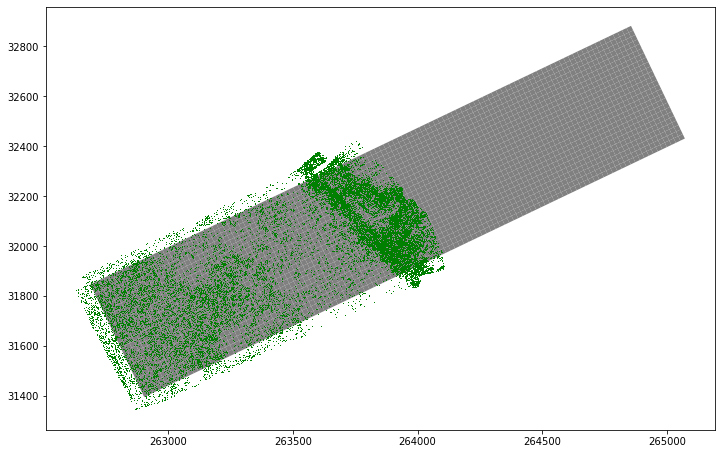

In [ ]:
# plot overlap
ax = forestgeo_grid.plot(color ='grey', figsize = (12,12))
lidar_grid.plot(ax=ax, color = 'green')
plt.show()

In [ ]:
# check the proportion of trees with LiDAR images that lie within the forestgeo grid 
cen = lidar_grid.geometry.centroid
lidar_grid['centroid_x'] = cen.x
lidar_grid['centroid_y'] = cen.y
lidar_grid.head()

,height,winRads,treeID,crownAr,crwnDmt,geometry,centroid_x,centroid_y
0,1.057,0.9171,1,0.25,0.564190,"POLYGON ((263740.500 32423.500, 263741.000 324...",263740.75,32423.25
1,0.557,0.7671,2,0.25,0.564190,"POLYGON ((263751.000 32422.000, 263751.500 324...",263751.25,32421.75
2,1.521,1.0563,3,1.00,1.128379,"POLYGON ((263750.500 32420.000, 263750.500 324...",263750.50,32420.25
3,0.698,0.8094,4,0.50,0.797885,"POLYGON ((263754.000 32419.000, 263754.500 324...",263754.50,32418.75
4,1.037,0.9111,5,1.25,1.261566,"POLYGON ((263755.500 32418.000, 263755.500 324...",263755.25,32418.25


In [ ]:
lidar_grid['latlong'] = [utm.to_latlon(lidar_grid['centroid_x'][i], lidar_grid['centroid_y'][i], 37, 'N') for i in range(len(lidar_grid))]
lidar_grid['latitude'] = [latlong[0] for latlong in lidar_grid['latlong']] 
lidar_grid['longitude'] = [latlong[1] for latlong in lidar_grid['latlong']] 
lidar_grid.head()

,height,winRads,treeID,crownAr,crwnDmt,geometry,centroid_x,centroid_y,latlong,latitude,longitude
0,1.057,0.9171,1,0.25,0.564190,"POLYGON ((263740.500 32423.500, 263741.000 324...",263740.75,32423.25,"(0.29314064654798244, 36.87725919781366)",0.293141,36.877259
1,0.557,0.7671,2,0.25,0.564190,"POLYGON ((263751.000 32422.000, 263751.500 324...",263751.25,32421.75,"(0.2931271029546435, 36.87735349725643)",0.293127,36.877353
2,1.521,1.0563,3,1.00,1.128379,"POLYGON ((263750.500 32420.000, 263750.500 324...",263750.50,32420.25,"(0.29311354007691165, 36.877346764318574)",0.293114,36.877347
3,0.698,0.8094,4,0.50,0.797885,"POLYGON ((263754.000 32419.000, 263754.500 324...",263754.50,32418.75,"(0.29309998534031406, 36.87738268949815)",0.293100,36.877383
4,1.037,0.9111,5,1.25,1.261566,"POLYGON ((263755.500 32418.000, 263755.500 324...",263755.25,32418.25,"(0.29309546609487025, 36.877389425841876)",0.293095,36.877389


In [ ]:
# matching attempt
match_digit = 4
lidar_grid['latitude_short'] = lidar_grid['latitude'].round(match_digit)
lidar_grid['longitude_short'] = lidar_grid['longitude'].round(match_digit)
forestgeo['latitude_short'] = forestgeo['latitude'].round(match_digit)
forestgeo['longitude_short'] = forestgeo['longitude'].round(match_digit)

pd.merge(forestgeo[forestgeo['Stem'] == 'main'][['TreeID', 'Latin', 'latitude_short', 'longitude_short']], lidar_grid[['treeID', 'latitude_short', 'longitude_short']], how='inner', on = ['latitude_short', 'longitude_short'])

,TreeID,Latin,latitude_short,longitude_short,treeID


In [ ]:
print(min(forestgeo.latitude)) 
print(max(forestgeo.latitude))
print(min(forestgeo.longitude))
print(max(forestgeo.longitude))

0.31809216077487606
0.3226136297995587
36.81070208767665
36.83226061800827


In [ ]:
print(min(lidar_grid.latitude))
print(max(lidar_grid.latitude))
print(min(lidar_grid.longitude))
print(max(lidar_grid.longitude))

0.28335676347362343
0.29314064654798244
36.867309699135554
36.8805739304556


In [ ]:
sample_tree = laspy.read(os.path.join(high_res_path, 'MpalaForestGEO_LasClippedtoTreePolygons', 'treeID_1.las'))
print(list(sample_tree.point_format.dimension_names)) 
sample_tree.X[:5]

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time', 'red', 'green', 'blue', 'HeightAboveGround']


array([26374078, 26374055, 26374095], dtype=int32)

In [ ]:
sample_tree.Y[:5]

array([3242315, 3242305, 3242304], dtype=int32)

In [ ]:
forestgeo_grid.sort_values(['top'], ascending = False)

,id,left,top,right,bottom,Quadrat,geometry
0,1.0,256330.0472,35684.7414,256350.0472,35664.7414,101,"POLYGON ((262689.296 31846.312, 262707.340 318..."
850,3401.0,257010.0472,35684.7414,257030.0472,35664.7414,3501,"POLYGON ((263302.789 32139.614, 263320.833 321..."
900,3601.0,257050.0472,35684.7414,257070.0472,35664.7414,3701,"POLYGON ((263338.877 32156.868, 263356.921 321..."
925,3701.0,257070.0472,35684.7414,257090.0472,35664.7414,3801,"POLYGON ((263356.921 32165.494, 263374.965 321..."
950,3801.0,257090.0472,35684.7414,257110.0472,35664.7414,3901,"POLYGON ((263374.965 32174.121, 263393.008 321..."
...,...,...,...,...,...,...,...
2174,8625.0,258050.0472,35204.7414,258070.0472,35184.7414,8725,"POLYGON ((264448.109 32155.142, 264466.153 321..."
2774,11025.0,258530.0472,35204.7414,258550.0472,35184.7414,11125,"POLYGON ((264881.163 32362.179, 264899.207 323..."
99,325.0,256390.0472,35204.7414,256410.0472,35184.7414,425,"POLYGON ((262950.465 31439.137, 262968.509 314..."
524,2025.0,256730.0472,35204.7414,256750.0472,35184.7414,2125,"POLYGON ((263257.212 31585.789, 263275.255 315..."


## Second attempt with georeferenced data from Tyler

In [12]:
forestgeo_boundary = geopandas.read_file(os.path.join(project_path, 'ForestGEO_Data', 'ForestGEO_Boundary.shp'))
forestgeo_grid = geopandas.read_file(os.path.join(project_path, 'ForestGEO_Data', 'ForestGEO_Georeferenced.shp'))
lidar_grid = geopandas.read_file(os.path.join(project_path, 'MpalaForestGEOPlotData', 'data', 'HighResAcquisitions', 'MpalaForestGEO_Shapefile050mCanopySegmentation', 'MpalaForestGEO_InitialCanopySegmentation_050m.shp'))

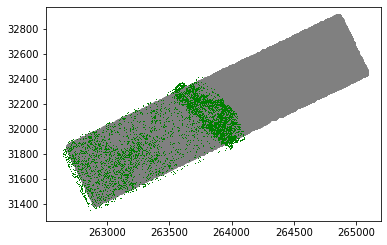

In [16]:
ax = forestgeo_grid.plot(color = 'grey')
lidar_grid.plot(ax=ax, color = 'green')

In [17]:
cen = lidar_grid.geometry.centroid
lidar_grid['centroid_x'] = cen.x
lidar_grid['centroid_y'] = cen.y
lidar_grid

,height,winRads,treeID,crownAr,crwnDmt,geometry,centroid_x,centroid_y
0,1.057,0.9171,1,0.25,0.564190,"POLYGON ((263740.500 32423.500, 263741.000 324...",263740.750000,32423.250000
1,0.557,0.7671,2,0.25,0.564190,"POLYGON ((263751.000 32422.000, 263751.500 324...",263751.250000,32421.750000
2,1.521,1.0563,3,1.00,1.128379,"POLYGON ((263750.500 32420.000, 263750.500 324...",263750.500000,32420.250000
3,0.698,0.8094,4,0.50,0.797885,"POLYGON ((263754.000 32419.000, 263754.500 324...",263754.500000,32418.750000
4,1.037,0.9111,5,1.25,1.261566,"POLYGON ((263755.500 32418.000, 263755.500 324...",263755.250000,32418.250000
...,...,...,...,...,...,...,...,...
43704,3.775,1.7325,43705,8.00,3.191538,"POLYGON ((262881.500 31347.000, 262881.500 313...",262879.703125,31348.296875
43705,3.152,1.5456,43706,2.50,1.784124,"POLYGON ((262869.000 31347.500, 262869.500 313...",262870.050000,31347.750000
43706,3.152,1.5456,43707,5.50,2.646284,"POLYGON ((262870.500 31345.000, 262870.500 313...",262870.204545,31345.954545
43707,3.758,1.7274,43708,22.25,5.322554,"POLYGON ((262875.000 31345.000, 262875.000 313...",262873.918539,31347.755618


In [25]:
print(forestgeo_grid.columns)
# subset to main trunks
forestgeo_main = forestgeo_grid[forestgeo_grid['Stem'] == 'main']
forestgeo_main

Index(['No.', 'Latin', 'Mnemonic', 'SubSpecies', 'Quadrat', 'PX', 'PY', 'PXE',
       'PXN', 'PYE', 'PYN', 'UTM Northi', 'UTM Eastin', 'TreeID', 'Tag',
       'StemID', 'StemTag', 'Census', 'DBH', 'HOM', 'Date', 'Codes', 'Stem',
       'Status', 'geometry'],
      dtype='object')


,No.,Latin,Mnemonic,SubSpecies,Quadrat,PX,PY,PXE,PXN,PYE,...,StemID,StemTag,Census,DBH,HOM,Date,Codes,Stem,Status,geometry
0,1,Acacia brevispica,ACACBR,None,221,36.30040,400.50461,32.713412,15.733777,-173.591757,...,254971,20847,1,77.0,0.5,11/20/12,None,main,alive,POINT (262768.592 31784.983)
1,2,Acacia brevispica,ACACBR,None,311,51.84520,206.57974,46.722168,22.471400,-89.538395,...,255478,30407,1,37.0,0.5,11/17/12,None,main,alive,POINT (262866.654 31616.958)
2,3,Acacia brevispica,ACACBR,None,503,81.23257,58.41180,73.205653,35.208844,-25.317579,...,257294,50086,1,50.0,0.5,11/23/12,None,main,alive,POINT (262957.358 31496.169)
3,4,Acacia brevispica,ACACBR,None,10001,1982.57861,9.46110,1786.672054,859.314212,-4.100749,...,262757,1000015,1,23.0,0.5,11/15/14,M,main,alive,POINT (264692.041 32276.160)
5,6,Acacia brevispica,ACACBR,None,10001,1985.44214,0.62931,1789.252627,860.555359,-0.272763,...,262759,1000017,1,20.0,0.5,11/15/14,None,main,alive,POINT (264698.450 32269.442)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364058,364059,Ziziphus mucronata,ZIZIMU,None,5611,1117.46606,217.50639,1007.044750,484.346226,-94.274361,...,396786,561401,1,31.0,0.5,9/19/14,M,main,alive,POINT (263822.240 32088.680)
364060,364061,Ziziphus mucronata,ZIZIMU,None,5613,1103.08386,243.72285,994.083713,478.112511,-105.637430,...,396849,561464,1,25.0,0.5,9/20/14,M,main,alive,POINT (263797.916 32106.072)
364062,364063,Ziziphus mucronata,ZIZIMU,None,8414,1678.51904,269.30026,1512.657832,727.524880,-116.723513,...,508238,844366,1,20.0,0.5,7/22/13,None,main,alive,POINT (264305.404 32378.535)
364063,364064,Ziziphus mucronata,ZIZIMU,None,9217,1838.66553,331.98471,1656.979604,796.937591,-143.892998,...,577445,926454,1,40.0,0.5,10/7/13,"M,Q",main,alive,POINT (264422.557 32504.438)


In [31]:
# match by UTM easting and northing
match_digit = 0

lidar_grid['easting_short'] = lidar_grid['centroid_x'].round(match_digit)
lidar_grid['northing_short'] = lidar_grid['centroid_y'].round(match_digit)
forestgeo_main['easting_short'] = forestgeo_main['UTM Eastin'].round(match_digit)
forestgeo_main['northing_short'] = forestgeo_main['UTM Northi'].round(match_digit)

matched = pd.merge(forestgeo_main[forestgeo_main['Stem'] == 'main'][['TreeID', 'Latin', 'easting_short', 'northing_short']], lidar_grid[['treeID', 'easting_short', 'northing_short']], how='inner', on = ['easting_short', 'northing_short'])
matched

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,TreeID,Latin,easting_short,northing_short,treeID
0,175788,Acacia brevispica,263530.0,32204.0,6147
1,176409,Acacia brevispica,263559.0,32216.0,5539
2,177097,Acacia brevispica,263567.0,32216.0,5540
3,177104,Acacia brevispica,263564.0,32220.0,5340
4,177105,Croton dichogamous,263564.0,32220.0,5340
...,...,...,...,...,...
4590,182851,Turraea mombassana,263614.0,32269.0,2955
4591,185984,Turraea mombassana,263692.0,32172.0,8033
4592,176400,Unidentified Unidentified,263560.0,32211.0,5768
4593,177011,Unidentified Unidentified,263587.0,32210.0,5844


In [32]:
# number of matched trees
len(matched['treeID'].unique())

3944

In [51]:
matched['Latin'].value_counts()

Acacia drepanolobium         1488
Croton dichogamous           1202
Euclea divinorum              588
Acacia brevispica             487
Acacia mellifera              140
Carissa spinarum              101
Rhus sp.                       68
Canthium pseudosetiforum       48
Acacia gerrardii               47
Pavetta gardeniifolia          43
Grewia kakothamnos             38
Pappea capensis                31
Boscia angustifolia            30
Psydrax sp.                    29
Scutia myrtina                 29
Tinnea aethiopica              28
Grewia sp.4                    25
Pyrostria sp.                  22
Rhus natalensis                21
Mystroxylon aethiopicum        20
Tarenna graveolens             17
Grewia sp.1                    14
Fagaropsis hildebrandtii        8
Acacia nilotica                 7
Grewia sp.2                     6
Turraea mombassana              6
Balanites aegypticus            6
Grewia sp.3                     5
Dichrostachys cinerea           5
Unidentified U

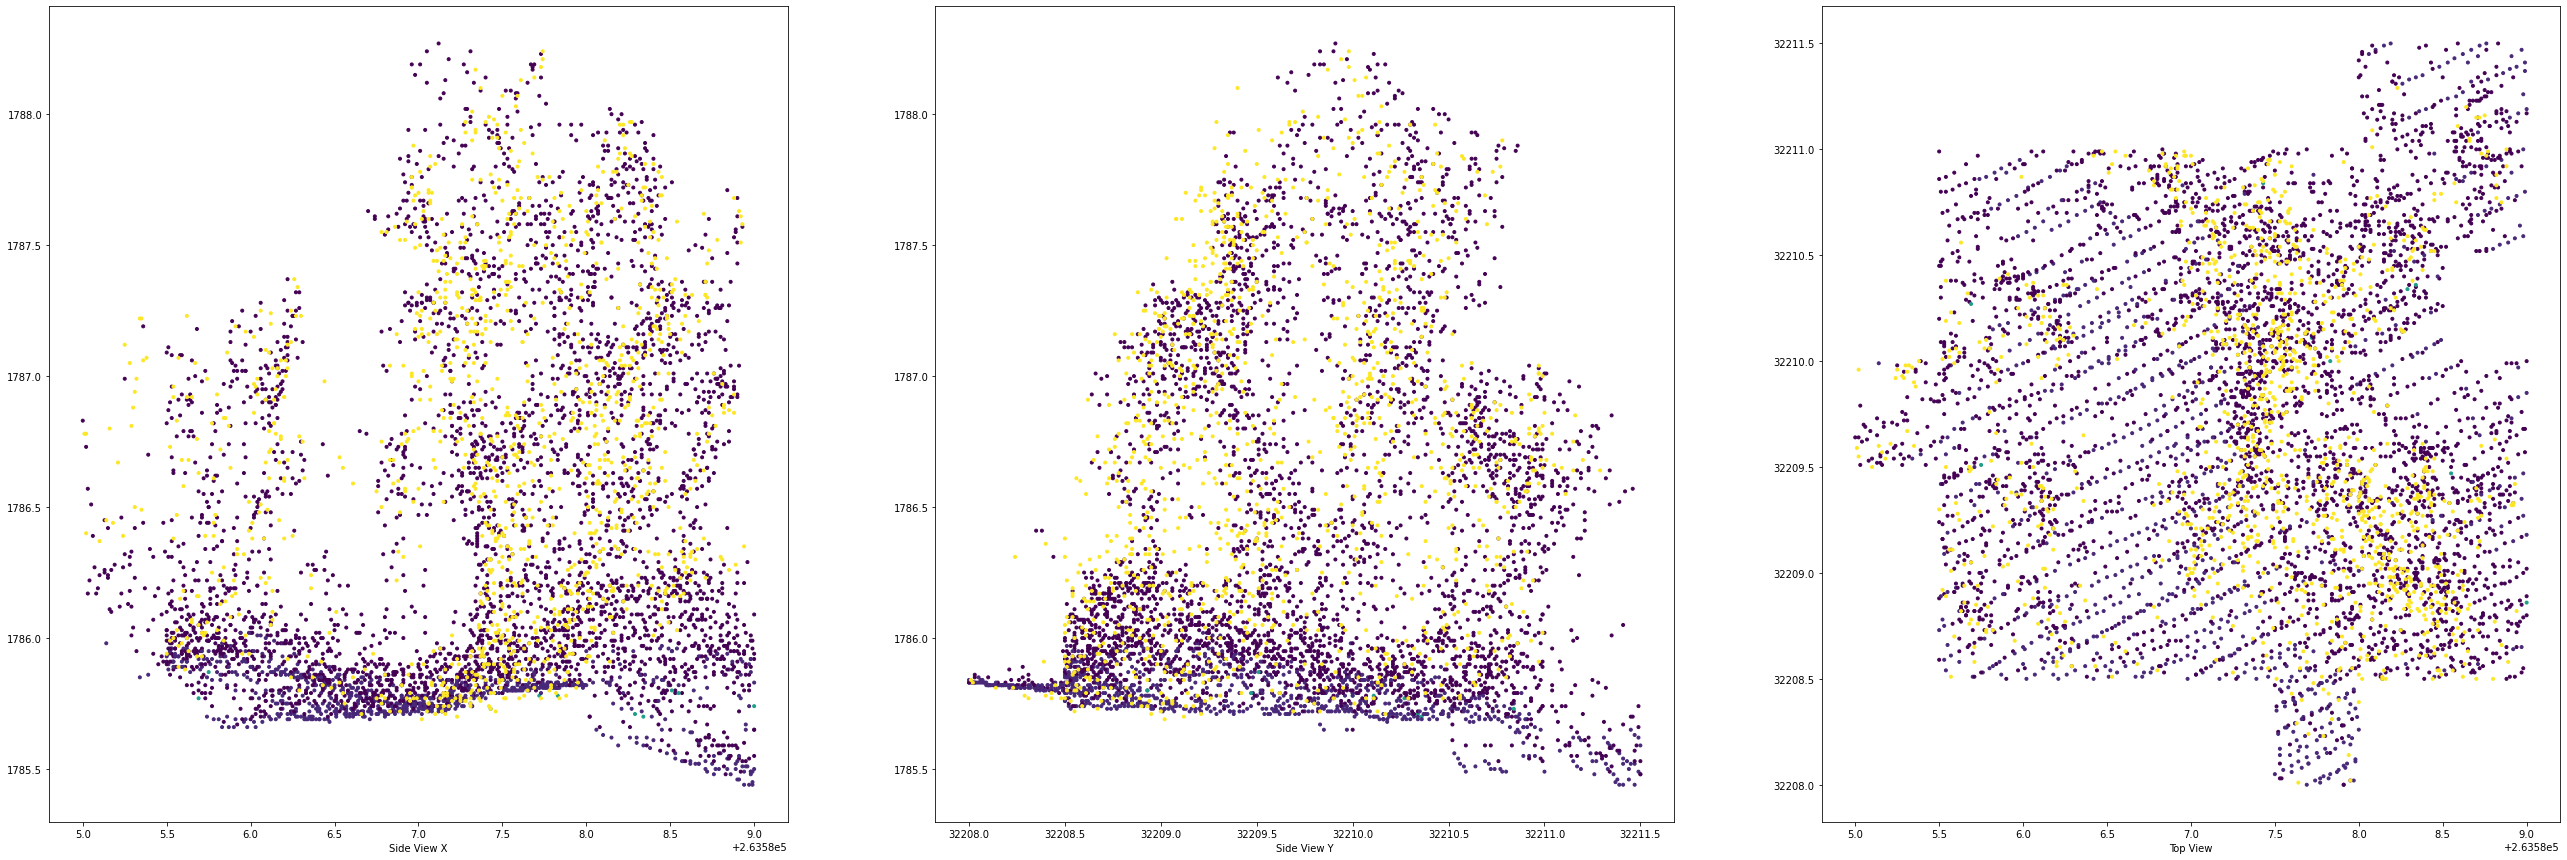

In [50]:
# visualize a sample tree
lidar_path = os.path.join(project_path, 'MpalaForestGEOPlotData', 'data')
high_res_path = os.path.join(lidar_path, 'HighResAcquisitions')
sample = laspy.read(os.path.join(high_res_path, 'MpalaForestGEO_LasClippedtoTreePolygons', 'treeID_5844.las'))

# scaling params
las_scaleX = sample.header.scale[0]
las_offsetX = sample.header.offset[0]
las_scaleY = sample.header.scale[1]
las_offsetY = sample.header.offset[1]
las_scaleZ = sample.header.scale[2]
las_offsetZ = sample.header.offset[2]

# calculating coordinates
point_records = sample.points.copy()
p_X = np.array((point_records['X'] * las_scaleX) + las_offsetX)
p_Y = np.array((point_records['Y'] * las_scaleY) + las_offsetY)
p_Z = np.array((point_records['Z'] * las_scaleZ) + las_offsetZ)
label = np.array(point_records.classification)

# plotting points
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(45,15))
# ax = fig.add_subplot(111)
ax0.scatter(p_X, p_Z, c=label, marker='.')
ax0.set_xlabel('Side View X')
ax1.scatter(p_Y, p_Z, c=label, marker='.')
ax1.set_xlabel('Side View Y')
ax2.scatter(p_X, p_Y, c=label, marker='.')
ax2.set_xlabel('Top View')
plt.show()